# Emergency Room Analysis

Kalasim provides a few built-in example simulation models. The [emergency room](https://www.kalasim.org/examples/emergency_room/) is one of them.

In [1]:
@file:Repository("*mavenLocal")

%useLatestDescriptors

// %use krangl

In [2]:
%use @/c:/brandl_data/projects/scheduling/kalasim/docs/kalasim.json

In [3]:
createSimulation(){
    Resource()
}

{
  "now": ".00",
  "queue": []
}


In [5]:

class Driver : Resource()
class TrafficLight : State<String>("red")

class Car : Component() {

    val trafficLight = get<TrafficLight>()
    val driver = get<Driver>()

    override fun process() = sequence {
        request(driver) {
            hold(1.0, description = "driving")

            wait(trafficLight, "green")
        }
    }
}

In [7]:
val sim = createSimulation(enableComponentLogger = true) {
    dependency { TrafficLight() }
    dependency { Driver() }

    Car()
}
    
sim.run(5.0)

time      current               receiver              action                                                 info                               
--------- --------------------- --------------------- ------------------------------------------------------ ----------------------------------
.00                             main                  Created
.00                             TrafficLight.1        Created                                                Initial value: red
.00                             Driver.1              Created                                                capacity=1
.00                             Car.1                 Created
.00                                                   Activated, scheduled for .00                           New state: scheduled
.00                             main                  Running +5.00, scheduled for 5.00                      New state: scheduled
.00       Car.1                 Car.1                 Requested 1.0 from 'Drive

## Entity Definition

In [4]:
// Define simulation types
class Fork : Resource()

class Philosopher(name: String, val leftFork: Fork, val rightFork: Fork) : Component(name) {
    val thinking = exponential(1)
    val eating = exponential(1)

    override fun process() = sequence {
        while(true) {
            hold(thinking())
            request(leftFork) {
                hold(0.1) // wait before taking the second fork
                request(rightFork) {
                    hold(eating())
                    log("$name is eating")
                }
            }
        }
    }
}

## Simulation

In [5]:
// run simulation
val sim = createSimulation {
    traceCollector()

    // create forks and resources
    val names = listOf("Socrates", "Pythagoras", "Plato", "Aristotle")
    val forks = repeat(names.size) { Fork() }
    names.forEachIndexed { idx, name ->
        Philosopher(name, forks[idx], forks[(idx + 1).rem(forks.size)])
    }

    run(100)
}

## Analysis

In [6]:
data class RequestRecord(val requester: String, val timestamp: Double, val resource: String, val quantity: Double)

val tc = sim.get<TraceCollector>()
val requests = tc.filterIsInstance<ResourceEvent>().map {
    val amountDirected = (if(it.type == ResourceEventType.RELEASED) -1 else 1) * it.amount
    RequestRecord(it.requester.name, it.time.value, it.resource.name, amountDirected)
}

val requestsDf = requests.asDataFrame()
    .groupBy("requester")
    .sortedBy("requester", "timestamp")
    .addColumn("end_time") { it["timestamp"].lead() }
    .filter { it["quantity"] gt 0 }
    .addColumn("state") { rowNumber.map { if(it.rem(2) == 0) "hungry" else "eating" } }
    .ungroup()

In [7]:
 requestsDf.schema()

Name Type Values quantity [Dbl] 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1... requester [Str] Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pythagoras, Pyth... resource [Str] Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork.2, Fork.3, Fork... timestamp [Dbl] 0.366, 0.466, 2.033, 5.903, 8.17, 11.108, 13.107, 14.125, 16.613, 17.834, 20.201, 21.242, 23.915, 26... end_time [Dbl] 0.466, 0.798, 5.903, 7.667, 11.108, 11.743, 14.125, 14.793, 17.834, 19.011, 21.242, 22.639, 26.769, ... state [Str] eating, hungry, eating, hungry, eating, hungry, eating, hungry, eating, hungry, eating, hungry, eati... DataFrame with 240 observations

Inspect the table with resource request data

In [8]:
requestsDf.head(10)


quantity requester resource timestamp end_time state 1.0 Pythagoras Fork.2 0.36644694351969087 0.46644694351969085 eating 1.0 Pythagoras Fork.3 0.46644694351969085 0.7975448471088381 hungry 1.0 Pythagoras Fork.2 2.0333581882924627 5.903115284737927 eating 1.0 Pythagoras Fork.3 5.903115284737927 7.667153147360637 hungry 1.0 Pythagoras Fork.2 8.169713960895557 11.107736094590045 eating 1.0 Pythagoras Fork.3 11.107736094590045 11.743329956261324 hungry ... with 4 more rows. Shape: 10 x 6.

Let's try to visualize these data similar to https://r-simmer.org/articles/simmer-08-philosophers.html

In [9]:
import kravis.*


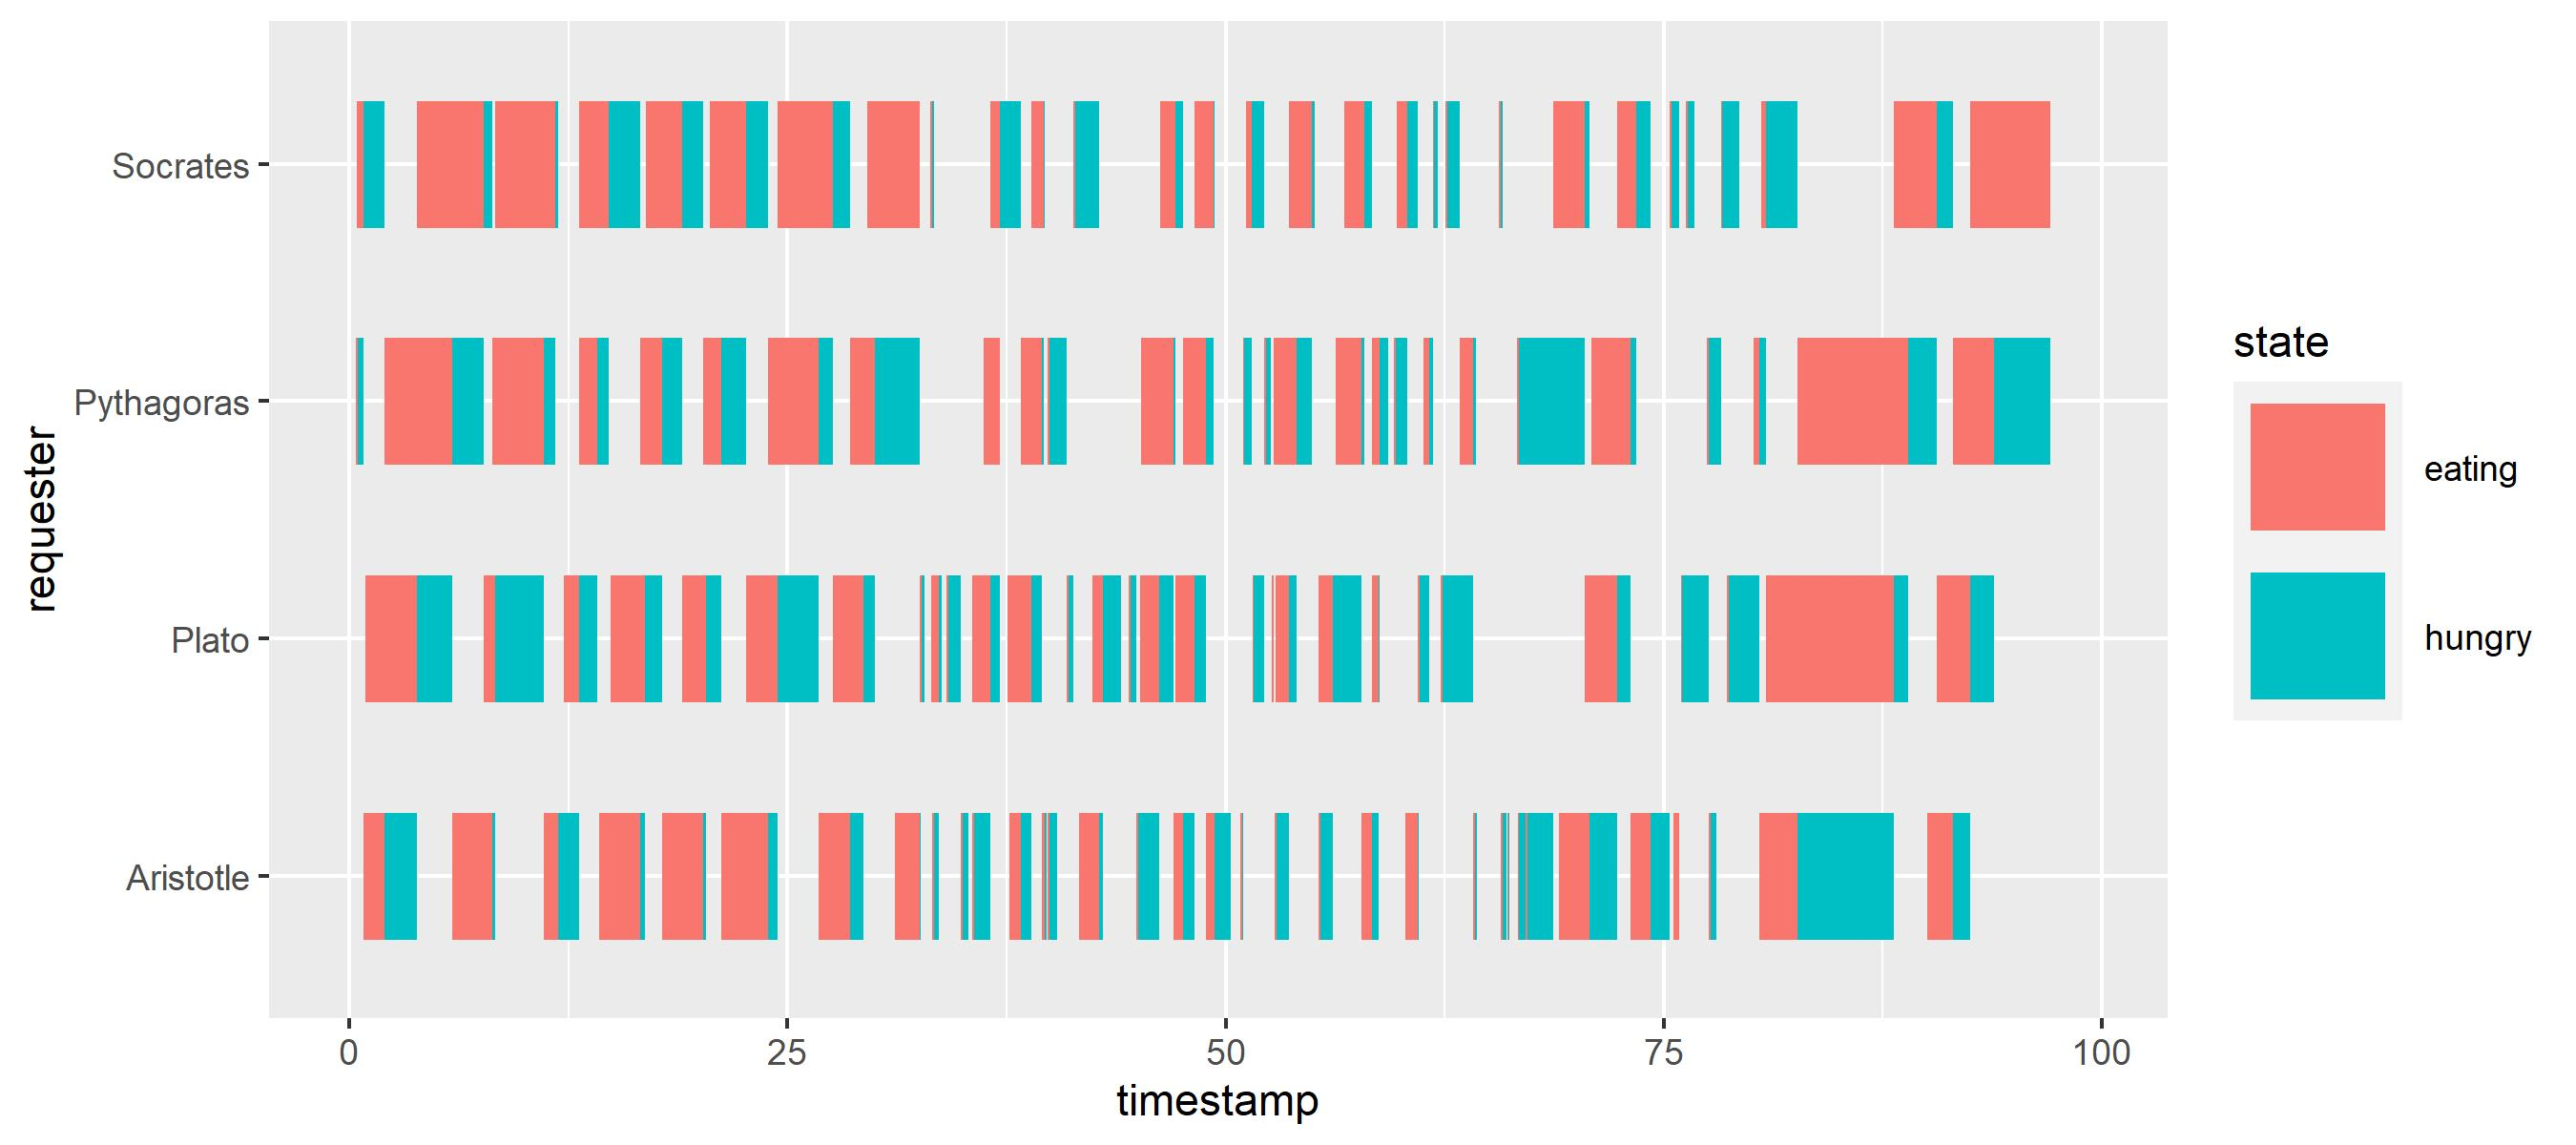

In [10]:
requestsDf.plot(x = "timestamp", xend = "end_time", y = "requester", yend = "requester", color = "state")
        .geomSegment(size = 15.0)

It is with great relief, that all 4 philosophers get a firm handle on 2 forks to enjory the tasty sphaghetti! 

In [11]:
%use lets-plot

In [12]:
letsPlot(requestsDf.toMap()){x="timestamp"; y="requester"; color="state"} + geomPoint(size=3)